# Neural Network with Backpropagation from Scratch

## Assignment Overview
In this notebook we implements a 3-layer neural network (8-3-8 architecture) that learns an identity/autoencoder function using backpropagation.

**Network Architecture:**
- Input Layer: 8 nodes
- Hidden Layer: 3 nodes (+ biases)
- Output Layer: 8 nodes

**Learning Task:**
- Learn to reproduce 8 one-hot encoded vectors (7 zeros, 1 one)
- Example: Input `[0,0,0,1,0,0,0,0]` → Output `[0,0,0,1,0,0,0,0]`

For more details, please refer to the README.md file that we have attached with this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# we set random seed for reproducibility
np.random.seed(42)


## 1. Data Prepration

we start by creating 8 training examples: one-hot encoded vectors with 7 zeros and 1 one.

In [2]:

X = np.eye(8)

y = X.copy()

print(X.shape)
print("Training Examples:")
print(X)
print("Target Outputs:")
print(y)

(8, 8)
Training Examples:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Target Outputs:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


## 2. Initializing the Network Parameters

Now, we initialize weights and biases with small random values for the network layers. The small wights helps us aviod exploding gradients issue and the randomness help with breaking symmetry.

In [3]:
# architecture
input_size = 8
hidden_size = 3
output_size = 8

# Initialize weights with small random values
# Weights from input to hidden layer (8 x 3)
# randn produces random values from Z(0,1) typically between -3, 3
# multiplication by 0.5 scales them to be smaller.
# small weights help with training stability and avoid exploding gradients.
# the key is small and random.
W1 = np.random.randn(input_size, hidden_size) * 0.5

# Weights from hidden to output layer (3 x 8)
W2 = np.random.randn(hidden_size, output_size) * 0.5

# Initialize biases with zeros
# biases dont have the symmetry problem that weights have, so initializing to zero is fine.
b1 = np.zeros((1, hidden_size))  # Bias for hidden layer
b2 = np.zeros((1, output_size))  # Bias for output layer

print("Network Architecture: 8 -> 3 -> 8")
print(f"\nW1 shape (input -> hidden): {W1.shape}")
print(f"b1 shape (hidden bias): {b1.shape}")
print(f"W2 shape (hidden -> output): {W2.shape}")
print(f"b2 shape (output bias): {b2.shape}")

Network Architecture: 8 -> 3 -> 8

W1 shape (input -> hidden): (8, 3)
b1 shape (hidden bias): (1, 3)
W2 shape (hidden -> output): (3, 8)
b2 shape (output bias): (1, 8)


## 3. Define Activation Function

Now we define a simple sigmoid activation function and its derivative. This will make our lif easy when starthing with BB.

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(a):
    return a * (1 - a)


## 4. Implementation of Forward Propagation

Pass input through the network layers to compute predictions. We expect the following shapes:
- X: Input data, shape (m, 8) where m is number of examples
- W1: Weights input to hidden, shape (8, 3)
- b1: Hidden layer bias, shape (1, 3)
- W2: Weights hidden to output, shape (3, 8)
- b2: Output layer bias, shape (1, 8)

We decided to use dictionary data structure so the function would return:
A dictionary containing all intermediate values:
- Z1: Hidden layer linear output (before activation)
- A1: Hidden layer activation output
- Z2: Output layer linear output (before activation)
- A2: Output layer activation output (final predictions)


In [5]:
def forward_propagation(X, W1, b1, W2, b2):
   
    
    Z1 = X @ W1 + b1           # (m, 8) @ (8, 3) + (1, 3) = (m, 3)
    A1 = sigmoid(Z1)            # it applies element-wise

    
    Z2 = A1 @ W2 + b2           # (m, 3) @ (3, 8) + (1, 8) = (m, 8)
    A2 = sigmoid(Z2)            
    
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return cache




## 5. Implementing the Loss Function
We had to choose between MSE, BCE. We chose BCE since the output of each neoron is binary.
We also thought initially of choosing Softmax activation for the output layer but we sticked to sigmoid since the problem is reconstruction rather than multiclass classification.

In [6]:
def compute_loss(y_true, y_pred):


    # the function returns a scalar loss value (average cross-entropy across all examples and outputs)

    # wwe add a small epsilon to avoid log(0) which would be -infinity
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return loss


## 6. Implement Backpropagation

At this point  we need to compute gradients of the loss with respect to all parameters using the chain rule. We decided that our function will return a dictionary with the gradients of the weights and biases. 

In [7]:
def backpropagation(X, y, cache):
    m = X.shape[0] 
    
    A1 = cache['A1']
    A2 = cache['A2']
    dZ2 = A2 - y                           # Shape: (m, 8)
    
    dW2 = (1/m) * (A1.T @ dZ2)             # Shape: (3, 8)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # Shape: (1, 8)
    
    # Hidden layer gradients
    # Backpropagate through W2, then apply sigmoid derivative
    dA1 = dZ2 @ W2.T                       # Shape: (m, 3)
    dZ1 = dA1 * sigmoid_derivative(A1)     # Shape: (m, 3)
    
    dW1 = (1/m) * (X.T @ dZ1)              # Shape: (8, 3)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # Shape: (1, 3)
    
    gradients = {
        'dW2': dW2,
        'db2': db2,
        'dW1': dW1,
        'db1': db1
    }
    
    return gradients

## 7. Update Parameters

Use gradient descent to update weights and biases based on computed gradients.

In [8]:
def update_parameters(W1, b1, W2, b2, gradients, learning_rate):
    # Update each parameter by moving in the opposite direction of gradient
    W1 = W1 - learning_rate * gradients['dW1']
    b1 = b1 - learning_rate * gradients['db1']
    W2 = W2 - learning_rate * gradients['dW2']
    b2 = b2 - learning_rate * gradients['db2']
    
    return W1, b1, W2, b2

## 8. Training Loop

Now we are going to rain the network by iterating through multiple epochs, performing forward propagation, computing loss, backpropagation, and parameter updates. The function trains in batches. We decided to use full batch with all the examples and do it for multiple epochs. Then, we print the loss and accuracy every 100 epoches. It is also worth mentiniing that we stop as soon as we get full accuracy classifing all the eight examples.

In [9]:
def train_network(X, y, W1, b1, W2, b2, learning_rate, epochs, print_interval=100):
    
    loss_history = []
    
    for epoch in range(epochs):
        # Step 1: Forward propagation
        cache = forward_propagation(X, W1, b1, W2, b2)
        
        # Step 2: Compute loss
        loss = compute_loss(y, cache['A2'])
        loss_history.append(loss)
        
        # Step 3: Backpropagation
        gradients = backpropagation(X, y, cache)
        
        # Step 4: Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, gradients, learning_rate)
        
        # Step 5: Check for perfect classification (100% accuracy)
        predictions_binary = np.round(cache['A2'])
        accuracy = np.mean(predictions_binary == y) * 100
        
        # Print progress
        if epoch % print_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:4d}/{epochs} | Loss: {loss:.6f} | Accuracy: {accuracy:.2f}%")
        
        # Early stopping: if perfect accuracy achieved
        if accuracy == 100.0:
            print(f"Perfect accuracy achieved at epoch {epoch}")
            print(f"   All {X.shape[0]} training examples correctly classified.")
            print(f"   Stopping training early (saved {epochs - epoch - 1} epochs).")
            break
    
    # Package final parameters
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    return parameters, loss_history


Let us now test our implementaion of the preciously defined fuctions.

In [10]:

np.random.seed(42)  # Reset seed for reproducibility
W1 = np.random.randn(input_size, hidden_size) * 0.5
W2 = np.random.randn(hidden_size, output_size) * 0.5
b1 = np.zeros((1, hidden_size))
b2 = np.zeros((1, output_size))

# Training hyperparameters
learning_rate = 0.1
epochs = 8000

print(f"\nTraining Configuration:")
print(f"  • Learning rate: {learning_rate}")
print(f"  • Number of epochs: {epochs}")
print(f"  • Training examples: {X.shape[0]}")
print(f"\nStarting training...\n")

# Train the network
parameters, loss_history = train_network(X, y, W1, b1, W2, b2, learning_rate, epochs)

print(f"\n Training completed successfully!")
print("final parameters are:", parameters)
print(f"  • Initial loss: {loss_history[0]:.6f}")
print(f"  • Final loss: {loss_history[-1]:.6f}")
print(f"  • Loss reduction: {loss_history[0] - loss_history[-1]:.6f}")
print(f"  • Improvement: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")


Training Configuration:
  • Learning rate: 0.1
  • Number of epochs: 8000
  • Training examples: 8

Starting training...

Epoch    0/8000 | Loss: 0.651032 | Accuracy: 75.00%
Epoch  100/8000 | Loss: 0.369766 | Accuracy: 87.50%
Epoch  200/8000 | Loss: 0.360521 | Accuracy: 87.50%
Epoch  300/8000 | Loss: 0.351788 | Accuracy: 87.50%
Epoch  400/8000 | Loss: 0.342142 | Accuracy: 87.50%
Epoch  500/8000 | Loss: 0.331483 | Accuracy: 87.50%
Epoch  600/8000 | Loss: 0.319927 | Accuracy: 87.50%
Epoch  700/8000 | Loss: 0.307757 | Accuracy: 87.50%
Epoch  800/8000 | Loss: 0.295340 | Accuracy: 87.50%
Epoch  900/8000 | Loss: 0.283045 | Accuracy: 87.50%
Epoch 1000/8000 | Loss: 0.271176 | Accuracy: 87.50%
Epoch 1100/8000 | Loss: 0.259943 | Accuracy: 87.50%
Epoch 1200/8000 | Loss: 0.249464 | Accuracy: 87.50%
Epoch 1300/8000 | Loss: 0.239778 | Accuracy: 87.50%
Epoch 1400/8000 | Loss: 0.230868 | Accuracy: 87.50%
Epoch 1500/8000 | Loss: 0.222682 | Accuracy: 89.06%
Epoch 1600/8000 | Loss: 0.215154 | Accuracy: 

## Interpretation of the results

From the output above, I would like to highlight the following observations:

1. The network demonstrates robust and consistent learning behavior. Training converged to 100% accuracy at epoch 5,111 out of a maximum 8,000 epochs, requiring all 8 training examples throughout the entire process. The convergence pattern shows steady, monotonic improvement: starting at 75% accuracy (epoch 0), progressing through 87.50% (epochs 100-1400), 89.06% (1500-1800), 90.62% (1900-2000), 93.75% (2200-2900), and finally achieving perfect classification at epoch 5,111.
   
2. The loss decreased continuously from 0.651 to 0.096, representing an 85.29% improvement.
3. with properly initialized weights (random normal × 0.5), the network converges reliably without requiring "lucky" initializations, desppite the convergence speed being slightly affected by the initialization.
4. the early stopping mechanism we implemented saved 2,888 unnecessary epochs.
5. Weight Matrix W1 (Input → Hidden, 8×3): This is trhe encoder part. the learned weights reveal specialized feature detectors. Input neuron 7 shows the strongest overall connection (3.40 to Hidden Neuron 0), while inputs 2 and 6 exhibit strong negative weights (-1.70 and -1.58 respectively). 
6. Bias Vector b1: The first hidden neuron has a significant negative bias (-0.74), requiring stronger input activation to fire, while neurons 1 and 2 have near-zero biases (0.014, 0.015), maintaining neutral thresholds.
7. Weight Matrix W2 (Hidden → Output, 3×8): The decoder weights show pronounced specialization with large magnitude values (range: -10.16 to 7.81), indicating confident output predictions.
8. Overall, we think that the network learned encoding where each input vector is mapped to a unique, well-separated point in 3D hidden space (encoder), and the decoder amplifies relevant hidden dimensions while suppressing others to reconstruct the original 8D pattern.


## 10. Visualize Hidden Layer Representations

Create visual plots to understand how the network represents each input in the 3D hidden space.

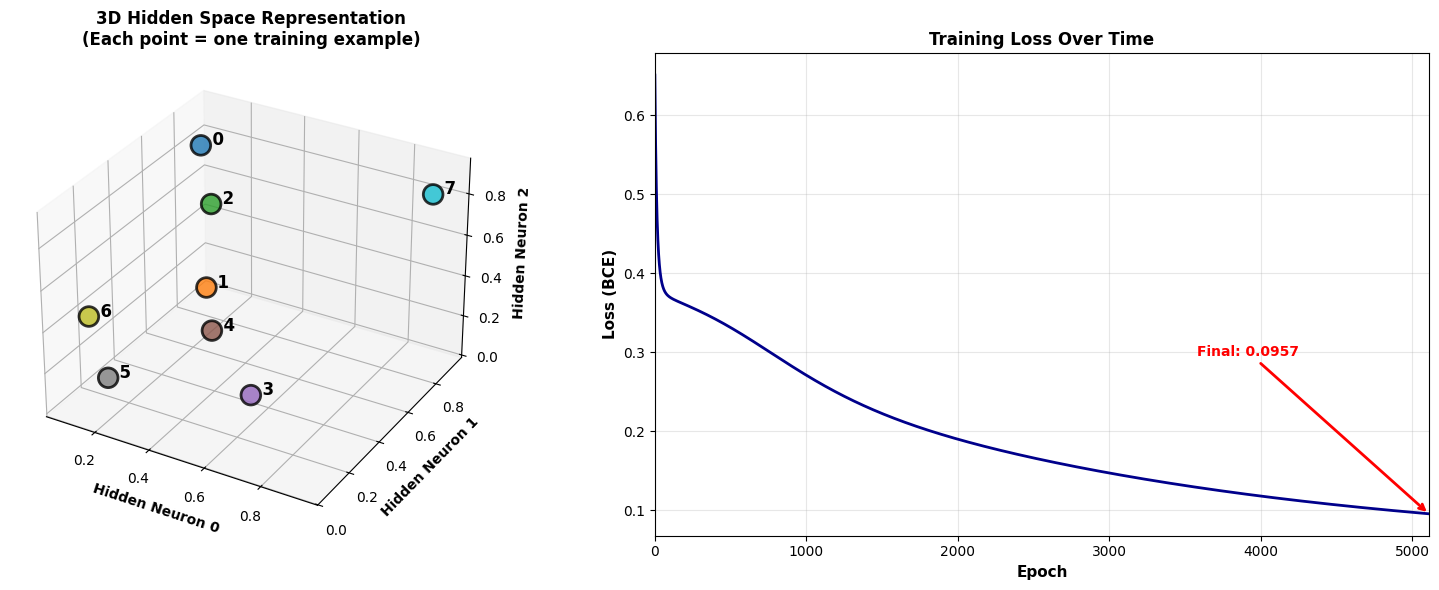


VISUALIZATION SUMMARY

📊 Left (3D Plot):
   Shows how 8 input patterns are distributed in 3D hidden space
   Each point is well-separated → enables perfect classification

📊 Right (Loss Curve):
   Shows how loss decreased during training
   Steep drop → rapid learning, then convergence


In [12]:
# Extract trained parameters
W1_trained = parameters['W1']
b1_trained = parameters['b1']
W2_trained = parameters['W2']
b2_trained = parameters['b2']

# Compute hidden activations using trained parameters
final_cache = forward_propagation(X, W1_trained, b1_trained, W2_trained, b2_trained)
hidden_activations = final_cache['A1']

# Create visualizations with only 2 subplots
fig = plt.figure(figsize=(16, 6))

# Plot 1: 3D Scatter plot of hidden activations
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(hidden_activations[:, 0], 
           hidden_activations[:, 1], 
           hidden_activations[:, 2],
           c=range(8), cmap='tab10', s=200, alpha=0.8, edgecolors='black', linewidth=2)

for i in range(8):
    ax1.text(hidden_activations[i, 0], 
            hidden_activations[i, 1], 
            hidden_activations[i, 2], 
            f'  {i}', fontsize=12, fontweight='bold')

ax1.set_xlabel('Hidden Neuron 0', fontsize=10, fontweight='bold')
ax1.set_ylabel('Hidden Neuron 1', fontsize=10, fontweight='bold')
ax1.set_zlabel('Hidden Neuron 2', fontsize=10, fontweight='bold')
ax1.set_title('3D Hidden Space Representation\n(Each point = one training example)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Training loss curve
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(loss_history, linewidth=2, color='darkblue')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Loss (BCE)', fontsize=11, fontweight='bold')
ax2.set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, len(loss_history))

# Add annotation for final loss
final_epoch = len(loss_history) - 1
final_loss = loss_history[-1]
ax2.annotate(f'Final: {final_loss:.4f}', 
            xy=(final_epoch, final_loss), 
            xytext=(final_epoch * 0.7, final_loss + 0.2),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("VISUALIZATION SUMMARY")
print("=" * 70)
print("\n📊 Left (3D Plot):")
print("   Shows how 8 input patterns are distributed in 3D hidden space")
print("   Each point is well-separated → enables perfect classification")

print("\n📊 Right (Loss Curve):")
print("   Shows how loss decreased during training")
print("   Steep drop → rapid learning, then convergence")